In [1]:
from scipy.optimize import curve_fit
import pandas as pd
import random
import sys
from IPython.display import clear_output
from matplotlib import pyplot as plt

sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import toxic_asset_attack, omnipool_arbitrage
from model.amm.global_state import GlobalState, historical_prices

In [2]:
import sys
import os
import glob
sys.path.append('../..')

from model import processing

prefix = 'FTTBUSD'
tick = '1s'

path = 'input/'
extension = 'csv'
os.chdir(path)
result = glob.glob(prefix + '-' + tick + '-' + '*.{}'.format(extension))
os.chdir('..')

# input_filename = 'input/DOTBUSD-1s-2022-11-22.csv'
print(result)
# input_filename = 'input/test.csv'
output_filename = 'output/' + prefix + "-" + tick + "-output.csv"

price_data = processing.import_binance_prices(path, result)
price_list = [{'DOT': data.price} for data in price_data[::180]]
print(price_list[0:10])

['FTTBUSD-1s-2022-11-07.csv', 'FTTBUSD-1s-2022-11-08.csv', 'FTTBUSD-1s-2022-11-09.csv']
[{'DOT': 22.26}, {'DOT': 22.26}, {'DOT': 22.24}, {'DOT': 22.31}, {'DOT': 22.32}, {'DOT': 22.41}, {'DOT': 22.46}, {'DOT': 22.4}, {'DOT': 22.36}, {'DOT': 22.35}]


In [17]:
# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'AUSD': {'usd price': 1, 'weight': 0.10},
    'ETH': {'usd price': 2500, 'weight': 0.40},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.20}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'Omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            lrna_fee=0,
            asset_fee=0,
            preferred_stablecoin = 'USD'
        )
    },
    agents={
        # 'Attacker': Agent(
        #     holdings={'USD': 0, 'AUSD': 1000000000},
        #     trade_strategy=toxic_asset_attack(
        #         pool_id='omnipool',
        #         asset_name='AUSD',
        #         trade_size=10000
        #     )
        # ),
        'Arbitrageur': Agent(
            holdings={tkn: float('inf') for tkn in assets}, 
            trade_strategy=omnipool_arbitrage('Omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
)
# print(initial_state)
time_steps = 1000  # len(price_list) - 1
events = run.run(initial_state, time_steps=time_steps)


Starting simulation...
Execution time: 8.036 seconds.


<AxesSubplot:title={'center':'pool: Omnipool  liquidity USD '}>

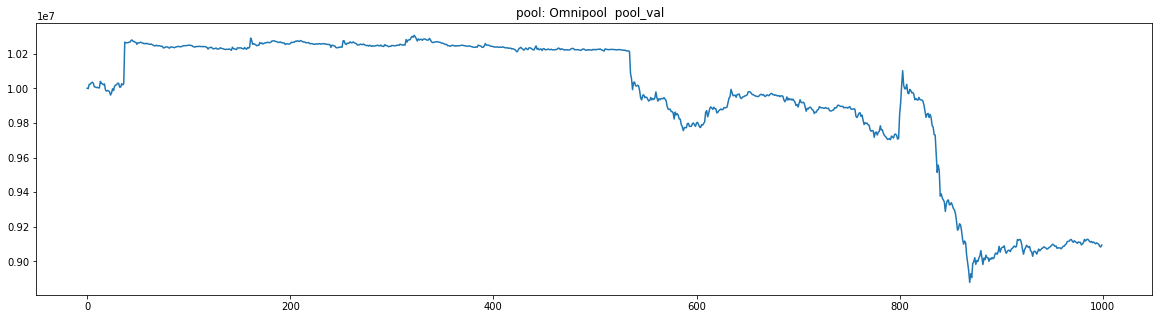

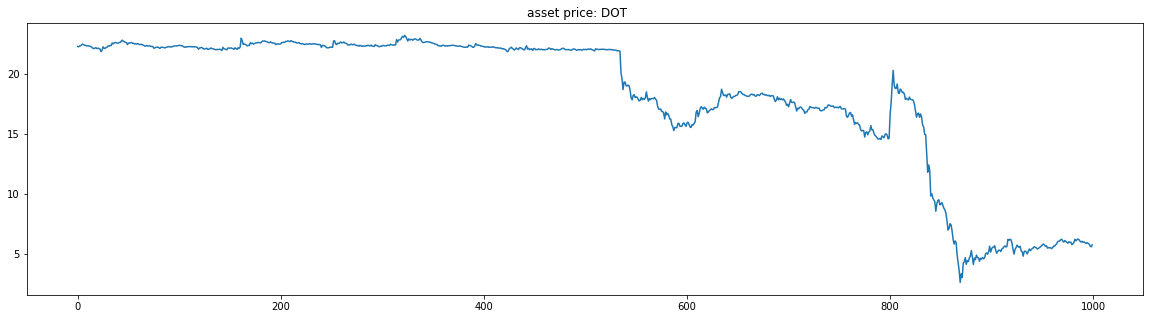

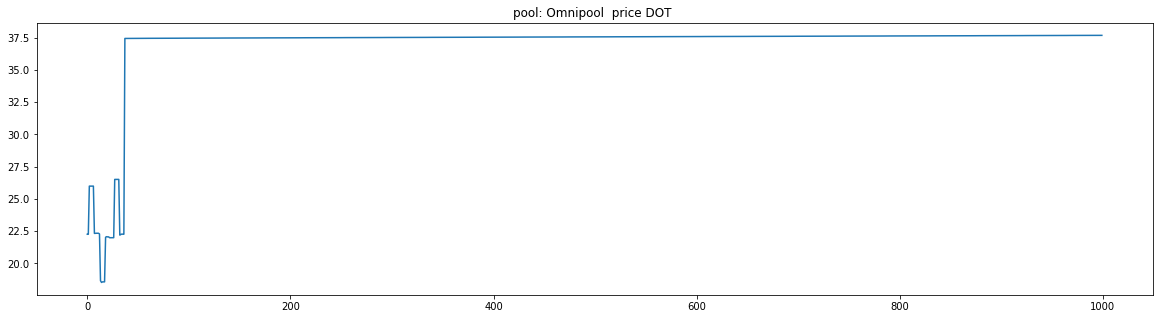

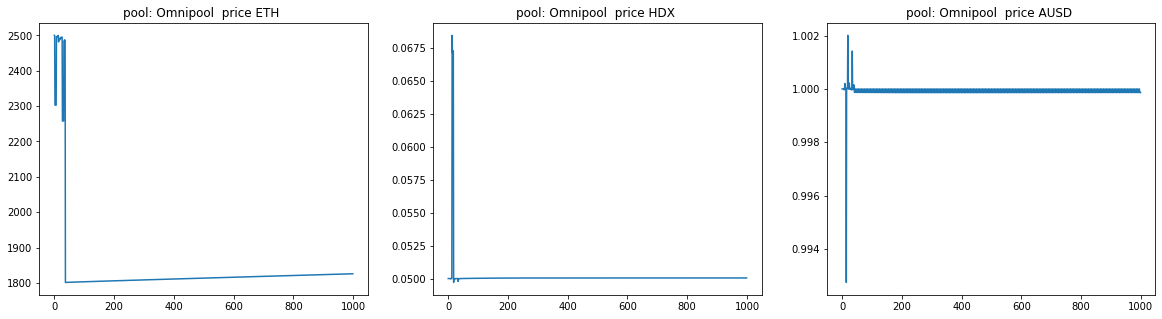

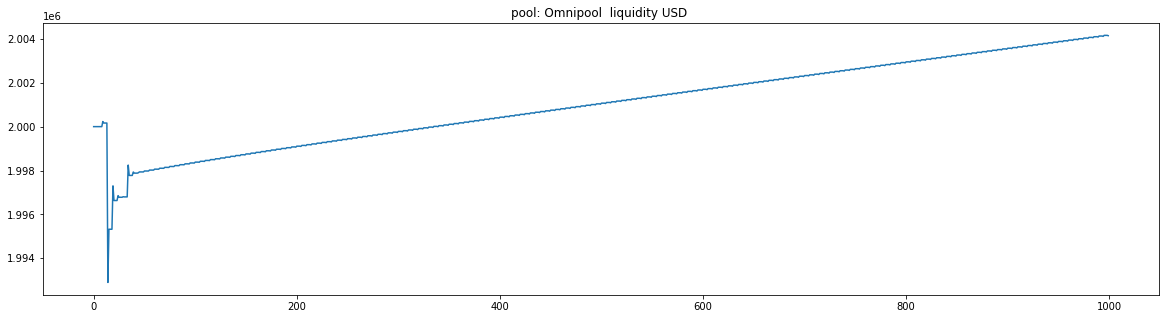

In [22]:
%matplotlib inline
events = processing.postprocessing(events, optional_params=['pool_val'])
pu.plot(events, pool='Omnipool', prop='pool_val')
ax = pu.plot(events, asset='DOT')
pu.plot(events, pool='Omnipool', prop='price', key='DOT')
pu.plot(events, pool='Omnipool', prop='price', key=['ETH', 'HDX', 'AUSD'])
pu.plot(events, pool='Omnipool', prop='liquidity', key='USD')

In [19]:
mitigated_state = initial_state.copy()
def press_brakes(self: OmnipoolState, tkn: str):
    f = 2
    min(self.short_oracle[tkn].get('volume_in') / self.long_oracle[tkn].get('volume_in'), 1)
# mitigated_state.pools['Omnipool'].liquidity_coefficient_function = press_brakes
events2 = run.run(mitigated_state, time_steps)

Starting simulation...
Execution time: 7.783 seconds.


Text(0.5, 1.0, 'ratio of short oracle(volume in, DOT) to long oracle')

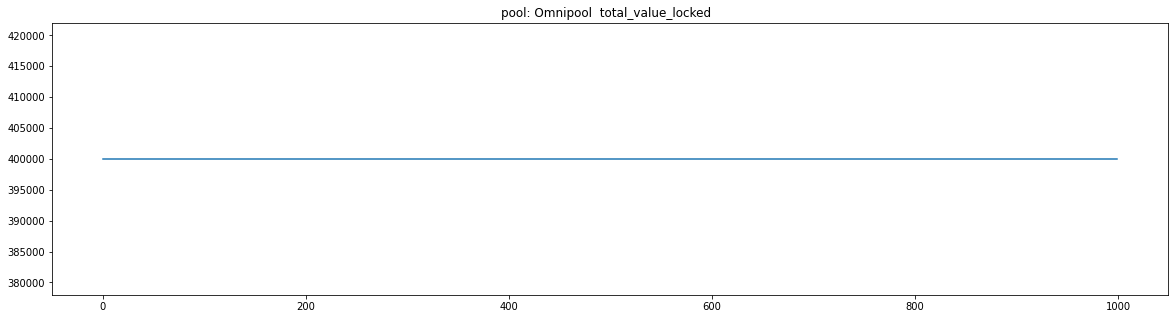

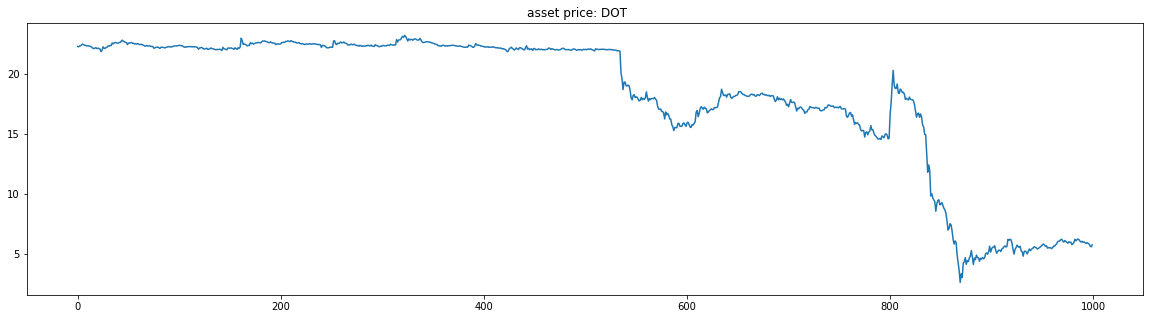

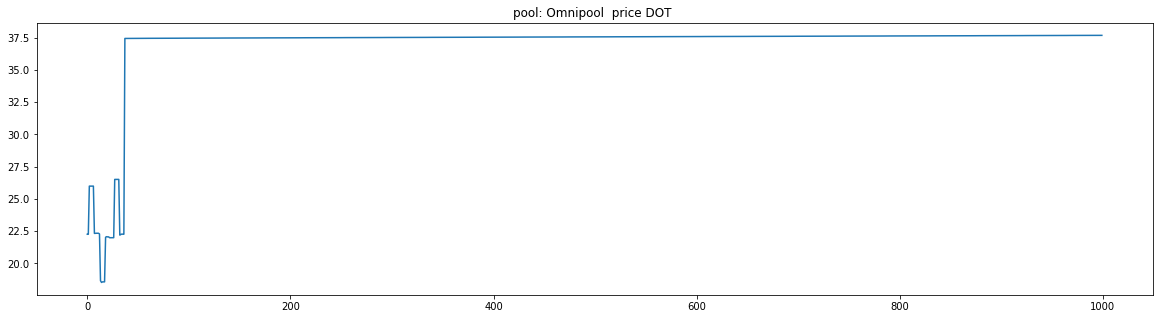

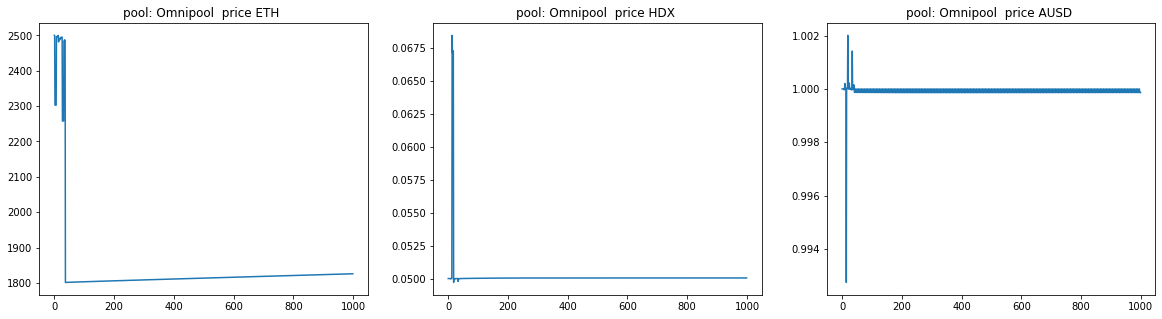

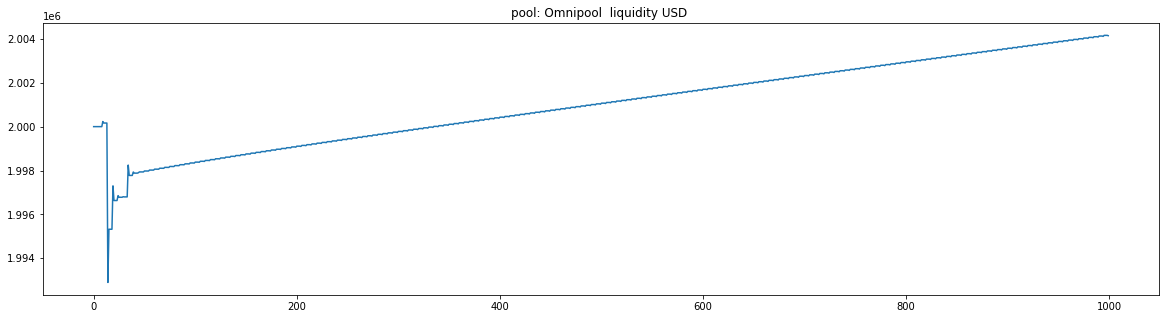

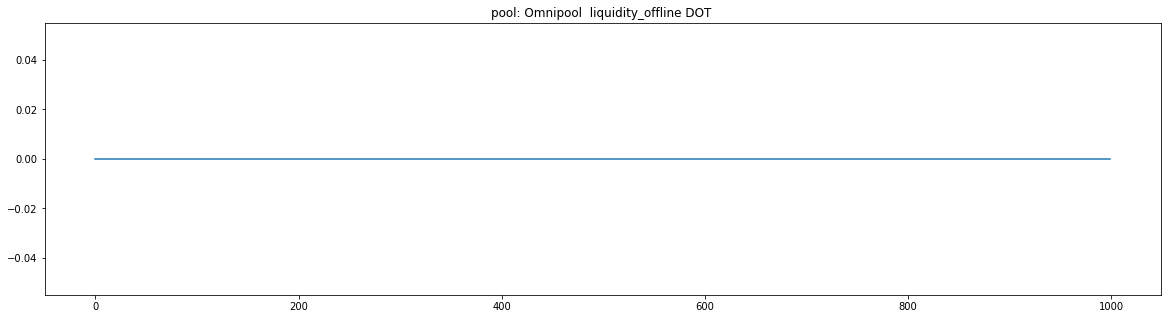

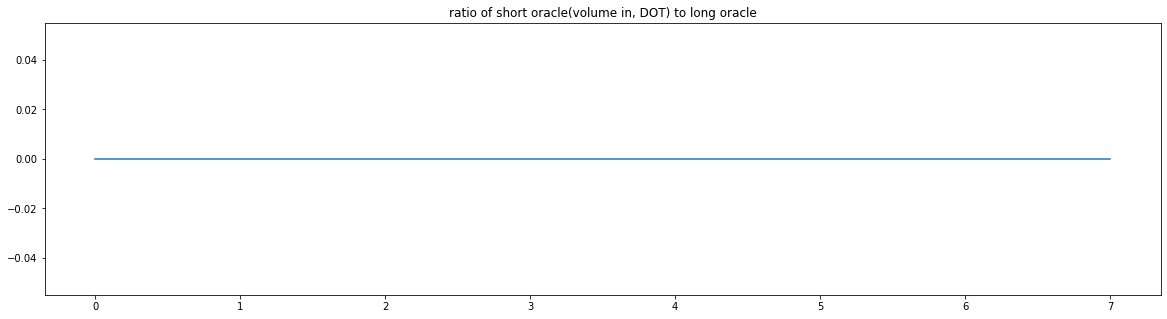

In [20]:
pu.plot(events2, pool='Omnipool', prop='total_value_locked')
ax = pu.plot(events, asset='DOT')
pu.plot(events2, pool='Omnipool', prop='price', key='DOT')
pu.plot(events2, pool='Omnipool', prop='price', key=['ETH', 'HDX', 'AUSD'])
pu.plot(events2, pool='Omnipool', prop='liquidity', key='USD')
pu.plot(events2, pool='Omnipool', prop='liquidity_offline', key='DOT')
trigger = [
    event['state'].pools['Omnipool'].short_oracle[tkn].get('volume_in') 
    / (event['state'].pools['Omnipool'].long_oracle[tkn].get('volume_in')  or 1)
    for event in events2
]
plt.figure(figsize=(20, 5))
plt.plot(range(len(events)), trigger)
plt.title('ratio of short oracle(volume in, DOT) to long oracle')

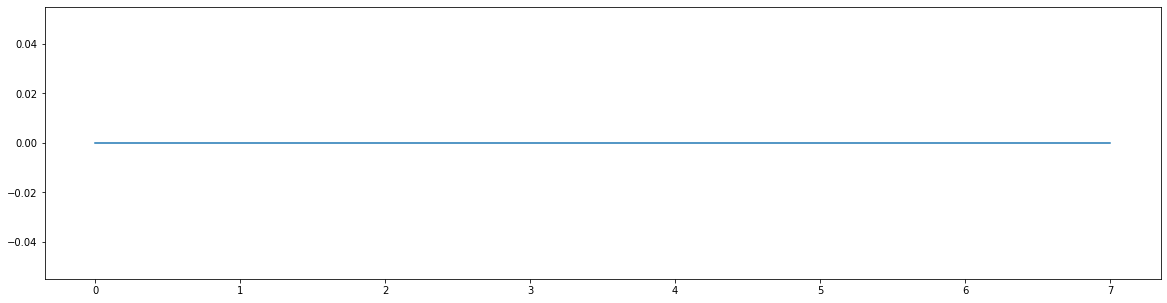

In [21]:
trigger = [
    event['state'].pools['Omnipool'].short_oracle['DOT'].get('volume_in') 
    # / (event['state'].pools['Omnipool'].long_oracle[tkn].get('volume_in') or 1)
    for event in events
]
plt.figure(figsize=(20, 5))
plt.plot(range(len(events)), trigger)